# The Classification of Pulsar Stars - Project Report
**By Oliver Gullery, Chan Le, Simon Lin, and Adam Parolin**

### Introduction

Pulsar stars are a rare type of neutron star that produce detectable radio emissions. Pulsars rotate and emit beams of electromagnetic radiation, which can be detected if they align directly with Earth. 

These beams take the form of radio waves - electromagnetic waves oscillating at specific frequencies that can be detected.

Using scientific equipment, we can scan for radio waves and discover new pulsar stars. However, some positive detections are caused by radio frequency interference, which makes real detections difficult to find. The main objective of our data analysis is determining if scientific equipment analyzed a real pulsar star or radio frequency interference.<br/> 

<img src="https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif

This leads into our question: 
__Using pulsar star candidate data recorded by scientific equipment, is a given candidate a true pulsar star or just radio frequency interference?__

Each observation in the data set (the <a href="https://archive.ics.uci.edu/ml/datasets/HTRU2">HTRU2 Data Set</a> by Rob Lyon) is a candidate, with 8 continuous variables:<br />
1. `mean_of_int_profiles` <br/>
2. `sd_of_int_profiles`<br />
3. `excess_kurtosis_of_int_profiles`<br />
4. `skewness_of_int_profiles`<br />
5. `mean_of_curve`<br />
6. `sd_of_curve`<br />
7. `excess_kurtosis_of_curve`<br />
8. `skewness_of_curve`<br />

... and one class variable:<br />
1. `true_pulsar`



### Method and Results

In [46]:
# Importing required libraries

library(tidyverse)
library(repr)
library(tidymodels)
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



We can download the dataset (https://archive.ics.uci.edu/ml/datasets/HTRU2) and import into JupyterHub.

In [47]:
# Downloading from url 
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
dir.create("data")
file <- download.file(url, "data/HTRU2.zip")

# Because the data we need is in a .zip file, we use the unzip() function in order to access "HTRU_2.csv"
star_data <- read_csv(unzip("data/HTRU2.zip", files = "HTRU_2.csv", exdir = "data/"), 
            col_names = c("mean_of_int_profiles", "sd_of_int_profiles", "excess_kurtosis_of_int_profiles",
            "skewness_of_int_profiles", "mean_of_curve", "sd_of_curve", 
            "excess_kurtosis_of_curve", "skewness_of_curve", "true_pulsar")) |>
    mutate(true_pulsar = as_factor(true_pulsar))
slice(star_data, 1:10)
# Below is a snapshot of the star data we will be working with

Warning message in dir.create("data"):
“'data' already exists”
Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_of_int_profiles, sd_of_int_profiles, excess_kurtosis_of_int_pr...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_of_int_profiles,sd_of_int_profiles,excess_kurtosis_of_int_profiles,skewness_of_int_profiles,mean_of_curve,sd_of_curve,excess_kurtosis_of_curve,skewness_of_curve,true_pulsar
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,0


#### Preliminary Exploratory Data Analysis

Before we begin classification, we will first take a closer look at our training data. For now, our intended predictor variables are going to be **mean_of_int_profiles** and **mean_of_curve**, but we will decide on our predictor variables later by using forward selection.

In [48]:
# Summarizing data into table counting the number of true and false pulsars
pulsar_frequency <- star_data |>
    group_by(true_pulsar) |>
    summarize(number = n())
pulsar_frequency

true_pulsar,number
<fct>,<int>
0,16259
1,1639


Here, we can see that there is a class imbalance - there are about 10 times more false pulsars than true pulsars! To solve this, we oversample the true pulsars in order to ensure that our classification is not skewed towards predicting false.

In [49]:
# Create upsampling recipe
ups_recipe <- recipe(true_pulsar ~ ., data = star_data) |>
  themis::step_upsample(true_pulsar, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          8

Training data contained 17898 data points and no missing data.

Operations:

Up-sampling based on true_pulsar [trained]

In [50]:
# Actually using recipe to create upsampled data set
upsampled_stars <- bake(ups_recipe, star_data)

upsampled_stars |>
  group_by(true_pulsar) |>
  summarize(number = n())

true_pulsar,number
<fct>,<int>
0,16259
1,16259


Now, we can explore our upsampled data further. Let's find the average values of our intended predictor variables for both true and false pulsars.

In [51]:
# Creating another table that shows the average of our intended predictor variables
pulsar_predictors <- upsampled_stars |>
    group_by(true_pulsar) |>
    summarize(avg_mean_of_int_profiles = mean(mean_of_int_profiles),
              avg_mean_of_curve = mean(mean_of_curve))

pulsar_predictors

true_pulsar,avg_mean_of_int_profiles,avg_mean_of_curve
<fct>,<dbl>,<dbl>
0,116.5627,8.863258
1,56.2561,50.312378


From this, we note that true pulsars have a mean of integrated profile around 57 and a mean of curve around 50, while false pulsars have a mean of integrated profile around 117 and a mean of curve around 9.

#### Preminary Visualization

We will now perform some visualization to get a sense of how the data looks.

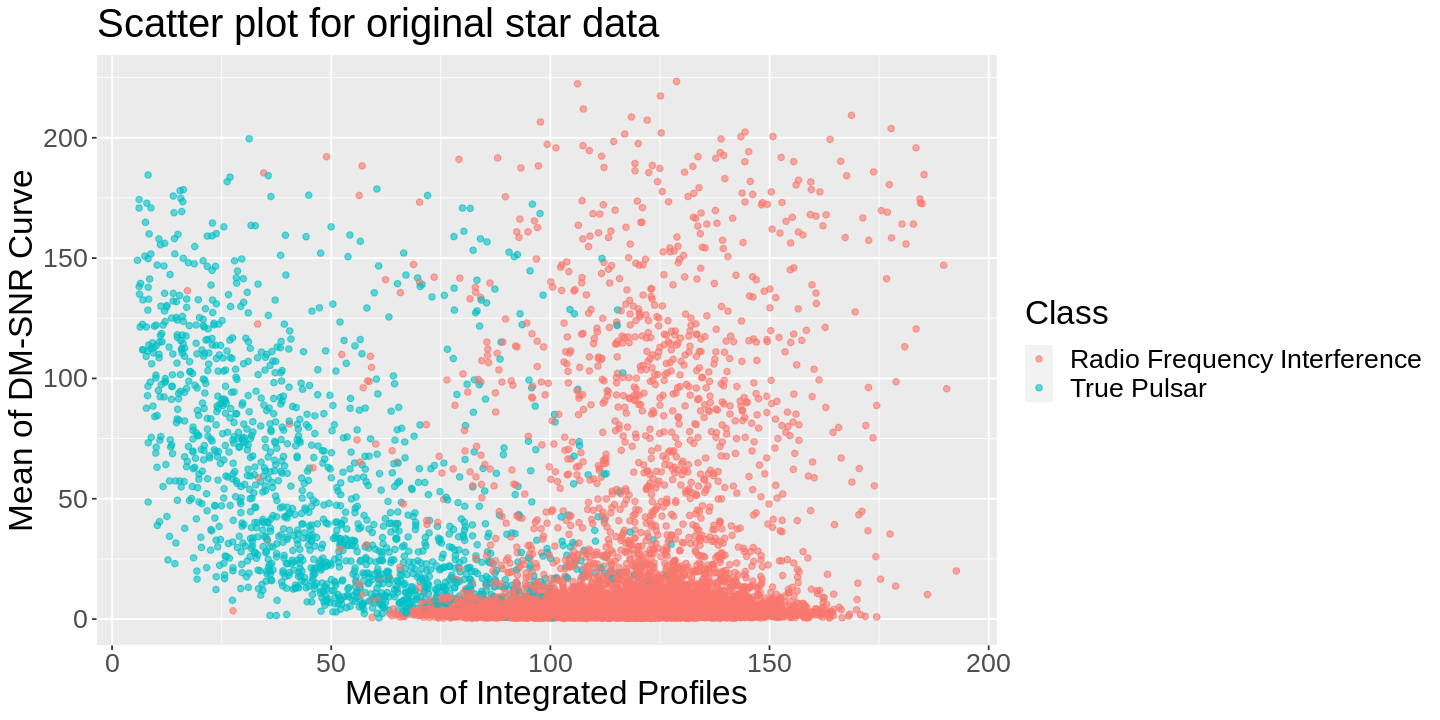

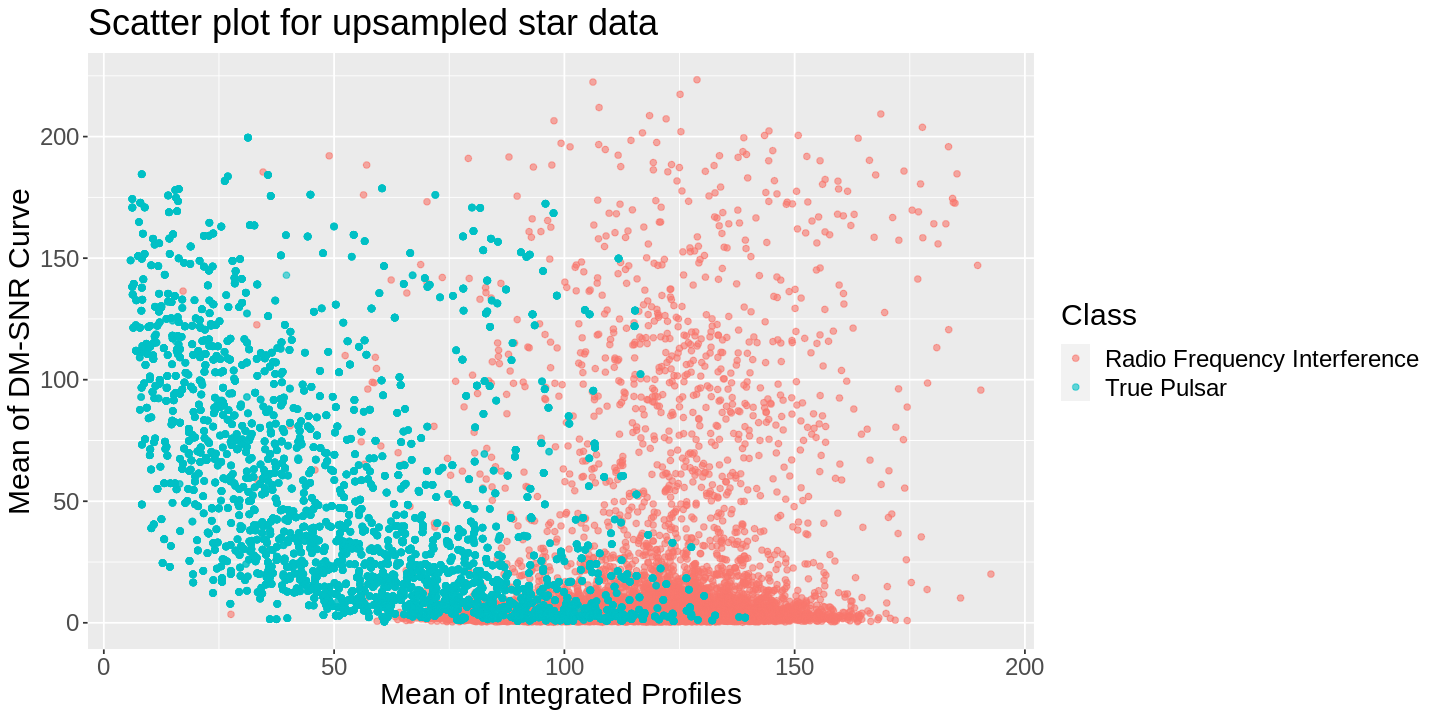

In [52]:
# Next, we will begin some visualization of our training data. We start by building scatter plots with Mean of Integrated Profiles on the x-axis 
# and Mean of DM-SNR Curve on the y-axis, with True Pulsars labeled by colour. We will build one with the original star data, and one with the 
# upsampled data.

# DO NOT REMOVE
set.seed(9999) 

# Visualizing the mean of integrated profiles and the mean of DM-SNR curve with colour to differentiate true pulsars
options(repr.plot.width = 12, repr.plot.height = 6)

pulsar_plot_ <- star_data |>
    ggplot(aes(x = mean_of_int_profiles, y = mean_of_curve)) +
           geom_point(aes(color = true_pulsar), alpha = 0.6) +
           labs(x = "Mean of Integrated Profiles", y = "Mean of DM-SNR Curve", color = "Class") +
           scale_color_discrete(labels=c('Radio Frequency Interference', 'True Pulsar')) + 
           theme(text = element_text(size = 20)) +
           ggtitle("Scatter plot for original star data")

pulsar_plot_

pulsar_plot_upsampled <- upsampled_stars |>
    ggplot(aes(x = mean_of_int_profiles, y = mean_of_curve)) +
           geom_point(aes(color = true_pulsar), alpha = 0.6) +
           labs(x = "Mean of Integrated Profiles", y = "Mean of DM-SNR Curve", color = "Class") +
           scale_color_discrete(labels=c('Radio Frequency Interference', 'True Pulsar')) + 
           theme(text = element_text(size = 18)) +
           ggtitle("Scatter plot for upsampled star data")

pulsar_plot_upsampled

Although the plots appear similar, we can see that for the upsampled plot, True Pulsars are more prominent near the bottom instead of being overshadowed by radio frequency interference.

#### Performing the classification

The first step is to split our data into a training and a testing set:

In [53]:
# DO NOT REMOVE
set.seed(9999) 

# Splitting data into training and testing, with true_pulsar as the strata
pulsar_split <- initial_split(upsampled_stars, prop = 0.75, strata = true_pulsar)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

### Discussion

__What did we find?__

__Is this what we expected to find?__

__What are the impacts of this finding?__
With the ability to confidently classify whether a star is pulsar or not, scientists could make enourmous strides in astronomy. By weeding out the fake pulsars and focusing only on the real ones, scientists can more accurately study what is happening inside real pulsars. Since neutron stars (which pulsars are) are the densest material in the universe, studying them can lead to enourmous discoveries related to the physics of the universe. Also, by weeding out the fake pulsars, scientists can focus in on the real pulsars and calculate cosmic distances.  This is because pulsar stars blink at regular intervals rivaled only by atomic clocks (https://www.space.com/32661-pulsars.html).  Overall, the ability to accurately predict whether a "pulsar event" in data is real or just interference is a major step in studying the universe beyond our own planet.

__What future questions are there?__
One big question is can this be applied to universes outside our own? If there are pulsar stars in our universe, there are likely stars like this in others.  Would the same algorithm for finding these stars apply outside our own universe?

Also, we must question if there are more accurate predictor variables that would work better? This also brings up, can we tune equipement in the field to also track in real time whether a reading is real or interference and filter it right away so scientists don't need to study it?

Given that this is just a predictive algorithm to determine if it is pulsar or interference, we must question the validity of the data and if the scientists behind it accurately classified the pulsars.

### References